# 6. Decision Trees and Ensemble Learning

Talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

Dataset: https://github.com/gastonstat/CreditScoring



In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [4]:
df = pd.read_csv(data)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [7]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [8]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4455.0,763317.0,8703625.0,0.0,80.0,120.0,166.0,99999999.0
assets,4455.0,1060341.0,10217569.0,0.0,0.0,3500.0,6000.0,99999999.0
debt,4455.0,404382.0,6344253.0,0.0,0.0,0.0,0.0,99999999.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


In [10]:
df.income.replace(to_replace=99999999, value=np.nan).max()

959.0

In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [12]:
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4421.0,131.0,86.0,0.0,80.0,120.0,165.0,959.0
assets,4408.0,5403.0,11573.0,0.0,0.0,3000.0,6000.0,300000.0
debt,4437.0,343.0,1246.0,0.0,0.0,0.0,0.0,30000.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


In [13]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [14]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [19]:
del df_train['status']
del df_val['status']
del df_test['status']

In [20]:
df_train.head().T

,0,1,2,3,4
seniority,10,6,1,1,5
home,owner,parents,parents,parents,owner
time,36,48,48,48,36
age,36,32,40,23,46
marital,married,single,married,single,married
records,no,yes,no,no,no
job,freelance,fixed,fixed,partime,freelance
expenses,75,35,75,35,60
income,0.0,85.0,121.0,72.0,100.0
assets,10000.0,0.0,0.0,0.0,4000.0


## 6.3 Decision trees

    How a decision tree looks like
    Training a decision tree
    Overfitting
    Controlling the size of a tree

In [21]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [22]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [23]:
assess_risk(xi)

'ok'

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [25]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [26]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [27]:
dv.get_feature_names_out(X_train)

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [29]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [30]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6524515027487829

In [31]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [32]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [33]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [34]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



6.4 Decision tree learning algorithm
- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [35]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [36]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [37]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [38]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


default    0.75
ok         0.25
Name: status, dtype: float64


In [39]:
from IPython.display import display

In [40]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [41]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [42]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [43]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [44]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

#####################


## 6.5 Decision trees parameter tuning
- selecting `max_depth`
- selecting `min_samples_leaf`


In [45]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.758
  10 -> 0.679
  15 -> 0.660
  20 -> 0.649
None -> 0.649


In [46]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        
        print('(%ds, %3d) -> %.3f' % (depth, s, auc))

(4s,   1) -> 0.761
(4s,   5) -> 0.761
(4s,  10) -> 0.761
(4s,  15) -> 0.764
(4s,  20) -> 0.761
(4s, 500) -> 0.680
(4s, 100) -> 0.756
(4s, 200) -> 0.747
(5s,   1) -> 0.766
(5s,   5) -> 0.768
(5s,  10) -> 0.762
(5s,  15) -> 0.773
(5s,  20) -> 0.774
(5s, 500) -> 0.680
(5s, 100) -> 0.763
(5s, 200) -> 0.759
(6s,   1) -> 0.762
(6s,   5) -> 0.762
(6s,  10) -> 0.778
(6s,  15) -> 0.786
(6s,  20) -> 0.773
(6s, 500) -> 0.680
(6s, 100) -> 0.776
(6s, 200) -> 0.768


In [47]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,5,0.761283
2,4,10,0.761283
3,4,15,0.763726
4,4,20,0.760910


In [48]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
19,6,15,0.785695
18,6,10,0.777803
22,6,100,0.776434
12,5,20,0.774028
20,6,20,0.773337
11,5,15,0.772723
23,6,200,0.768267
9,5,5,0.767755
8,5,1,0.766496
3,4,15,0.763726


In [49]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.762
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.773  0.786
20                0.761  0.774  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

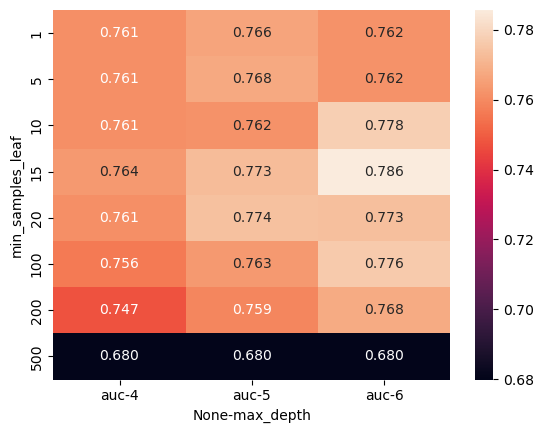

In [50]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [51]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [52]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- income <= 117.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  117.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## 6.6 Ensembles and random forest
- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [55]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


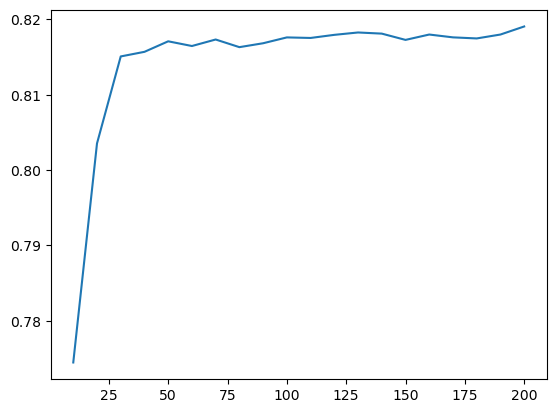

In [56]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [57]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [58]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


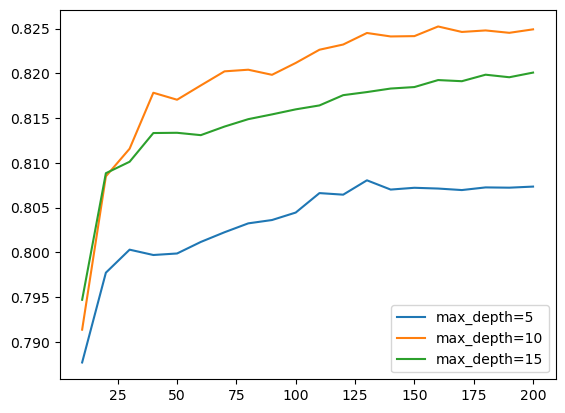

In [59]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [60]:
max_depth = 10

In [61]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [62]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


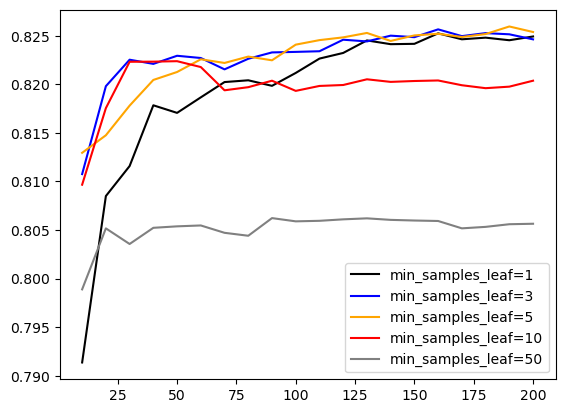

In [63]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [64]:
min_samples_leaf = 3

In [65]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

Other useful parametes:
- max_features
- bootstrap

## 6.7 Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [66]:
!pip install xgboost

You should consider upgrading via the '/home/pinku/miniconda3/bin/python -m pip install --upgrade pip' command.


In [67]:
import xgboost as xgb

In [68]:
features = dv.get_feature_names_out().tolist()

In [69]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)

In [70]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [71]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [72]:
y_pred = model.predict(dval)

In [73]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [74]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [75]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [76]:
print(output.stdout)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [77]:
s = output.stdout

In [78]:
s.split('\n')

['[0]\ttrain-auc:0.86730\tval-auc:0.77938',
 '[5]\ttrain-auc:0.93086\tval-auc:0.80858',
 '[10]\ttrain-auc:0.95447\tval-auc:0.80851',
 '[15]\ttrain-auc:0.96554\tval-auc:0.81334',
 '[20]\ttrain-auc:0.97464\tval-auc:0.81729',
 '[25]\ttrain-auc:0.97953\tval-auc:0.81686',
 '[30]\ttrain-auc:0.98579\tval-auc:0.81543',
 '[35]\ttrain-auc:0.99011\tval-auc:0.81206',
 '[40]\ttrain-auc:0.99421\tval-auc:0.80922',
 '[45]\ttrain-auc:0.99548\tval-auc:0.80842',
 '[50]\ttrain-auc:0.99653\tval-auc:0.80918',
 '[55]\ttrain-auc:0.99765\tval-auc:0.81114',
 '[60]\ttrain-auc:0.99817\tval-auc:0.81172',
 '[65]\ttrain-auc:0.99887\tval-auc:0.80798',
 '[70]\ttrain-auc:0.99934\tval-auc:0.80870',
 '[75]\ttrain-auc:0.99965\tval-auc:0.80555',
 '[80]\ttrain-auc:0.99979\tval-auc:0.80549',
 '[85]\ttrain-auc:0.99988\tval-auc:0.80374',
 '[90]\ttrain-auc:0.99993\tval-auc:0.80409',
 '[95]\ttrain-auc:0.99996\tval-auc:0.80548',
 '[100]\ttrain-auc:0.99998\tval-auc:0.80509',
 '[105]\ttrain-auc:0.99999\tval-auc:0.80629',
 '[110]\tt

In [79]:
line = s.split('\n')[0]

In [80]:
line.split('\t')

['[0]', 'train-auc:0.86730', 'val-auc:0.77938']

In [81]:
num_iter, train_auc, val_auc = line.split('\t')

In [82]:
int(num_iter.strip('[]'))

0

In [83]:
float(train_auc.split(':')[1])

0.8673

In [84]:
float(val_auc.split(':')[1])

0.77938

In [85]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [86]:
df_score = parse_xgb_output(output)

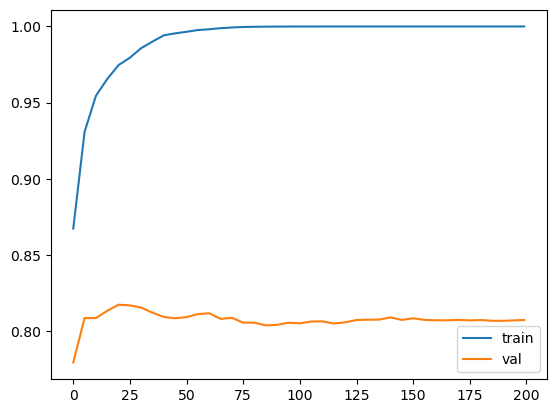

In [87]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

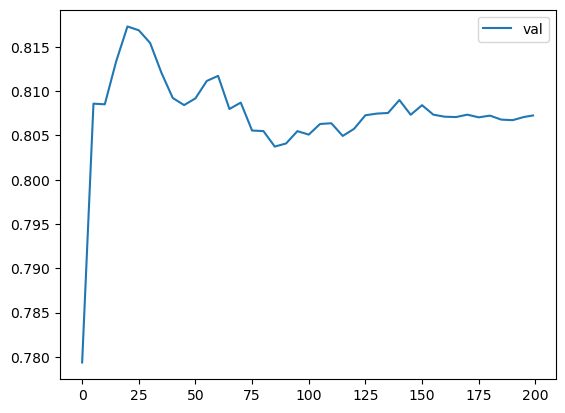

In [88]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:
- eta
- max_depth
- min_child_weight

In [89]:
%%capture output

scores = {}

etas = [1.0, 0.3, 0.1, 0.01, 0.05]

for eta in etas:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)
    key = 'eta=%s' % (xgb_params['eta'])
    scores[key] = parse_xgb_output(output)

In [90]:
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842


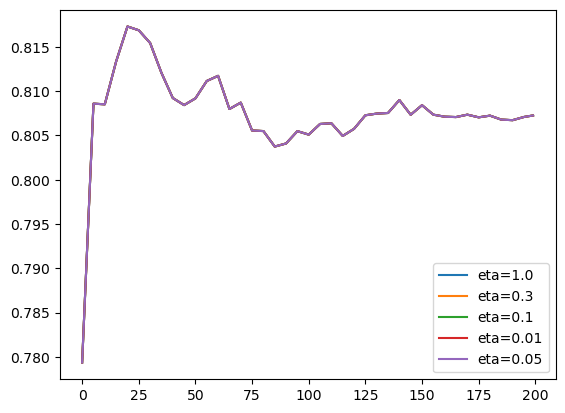

In [91]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1', 'eta=0.01', 'eta=0.05']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

In [92]:
%%capture output

scores = {}

for depth in [3, 4, 6, 10]:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': depth,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

    key = 'max_depth=%s' % (xgb_params['max_depth'])
    scores[key] = parse_xgb_output(output)

max_depth: max_depth=3
max_depth: max_depth=4
max_depth: max_depth=6
max_depth: max_depth=10


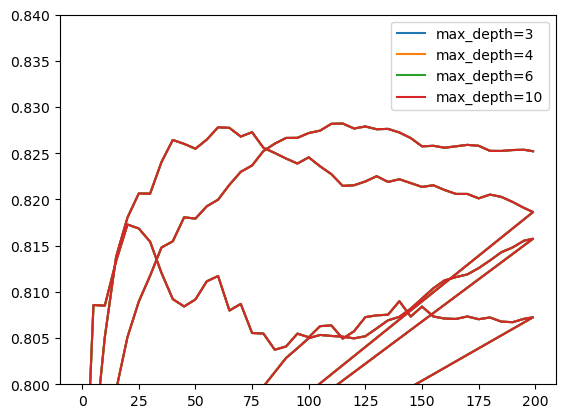

In [93]:
for max_depth, df_score in scores.items():
    print("max_depth:", max_depth)
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

In [94]:
%%capture output

scores = {}

for w in [1, 10, 30]:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': 3,
        'min_child_weight': w,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

    key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
    scores[key] = parse_xgb_output(output)

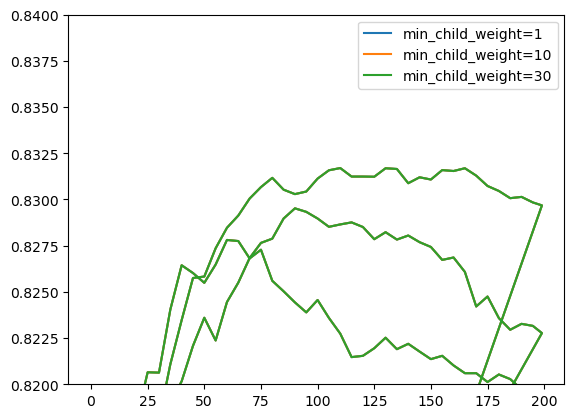

In [95]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [96]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:
- subsample and colsample_bytree
- lambda and alpha

## 6.9 Selecting the final model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [97]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [98]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [99]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [100]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [101]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [102]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

In [103]:
df_full_train = df_full_train.reset_index(drop=True)

In [104]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [105]:
del df_full_train['status']

In [106]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [109]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [110]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [111]:
y_pred = model.predict(dtest)

In [112]:
roc_auc_score(y_test, y_pred)

0.8289367577342261

## 6.10 Summary
- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.